# Exercises for <i>Bayesian Statistics The Fun Way</i>

## Chapter 12: Modelling snowfall measurements

In [2]:
# Determining distribution parameters (this problem calls for a normal distribution)

import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt

measurements = [7.8,9.4,10,7.9,9.4,7,7,7.1,8.9,7.4]
x_bar = np.mean(measurements)
stdev = np.std(measurements)

print(x_bar, stdev)

8.190000000000001 1.076522178127325


Text(0.5, 0, 'snowfall (in)')

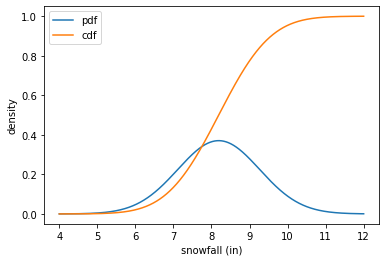

In [3]:
# Plotting probability density function (pdf) and cumulative density function (cdf)

x = np.linspace(4, 12, 5000)

y_pdf = ss.norm.pdf(x, x_bar, stdev) # the normal pdf
y_cdf = ss.norm.cdf(x, x_bar, stdev) # the normal cdf

plt.plot(x, y_pdf, label='pdf')
plt.plot(x, y_cdf, label='cdf')
plt.legend()
plt.ylabel('density')
plt.xlabel('snowfall (in)')

## Chapter 13: Parameter estimation

A child is going door-to-door selling candy bars. So far, 10 out of 30 households have bought some. They're planning on visiting 40 more houses - what is the 95% confidence interval for their sales?

In [1]:
# This problem calls for a Beta distribution, which is defined by 
# succeses (alpha) and failures (beta),
# and which models the probability of success. 
# Defining parameters of distribution

import scipy.stats as ss
alpha = 10
beta = 20

# Calculating bounds of 95% confidence interval for the proability of success,
# i.e. for the probability of selling a candy bar.

lower_bound_rate = ss.beta.ppf(0.025, alpha, beta)
lower_bound_rate

upper_bound_rate = ss.beta.ppf(0.975, alpha, beta)
upper_bound_rate

print(lower_bound_rate, upper_bound_rate)

0.17938364923511183 0.50832335380999


In [2]:
# Calculates 95% confidence interval in terms of
# candy bars sold from the probabilities.

k_future = 40
lower, upper = (round(lower_bound_rate*k_future,0), round(upper_bound_rate*k_future,0))

print(lower, upper)

7.0 20.0


Based on the data we have, we can be 95% certain that their true conversion rate is between ~18% and ~51%.<br>
Consequently, we can be 95% confident that they will sell between 7 and 20 candy bars visiting the next 40 houses. 

## Chapter 15: Building a simple bayesian A/B test using beta distributions and Monte Carlo simulations

We are comparing variants A and B of a newsletter, the goal being to determine which one has a higher click through rate. Currently, 150 of each have been sent out, and the results are as follows:
- Variant A: 36 clicked, 114 not clicked 
- Variant B: 50 clicked, 100 not clicked

(Both seems pretty high, but let's see if we can find a meaningful difference)

### Q1.
Our boss strongly believes that there will be no difference, and that both variants will be close to our historical average of 30%. <br> How can we integrate this in our model?

In [1]:
# Problem calls for a Beta distribution. 
# The expectation of no difference should be incorporated
# by making the prior a strong one.

# Defining prior, likelihoods for variants A/B,
# and posterior Beta distributions.
import scipy.stats as ss
import numpy as np

strong_prior = (300,700)

likelihood_a = (36,114)
likelihood_b = (50,100)

posterior_a = (strong_prior[0] + likelihood_a[0],strong_prior[1] + likelihood_a[1])
posterior_b = (strong_prior[0] + likelihood_b[0],strong_prior[1] + likelihood_b[1])

print(posterior_a, posterior_b)

(336, 814) (350, 800)


Even with a strong prior, variant B seems to be slightly ahead. Let's quantify this using Monte Carlo simulations.

In [2]:
# Picking n random samples from each posterior Beta distribution.
# These represent possible click through rates for the variants.

n = 100000

a_samples = np.random.beta(posterior_a[0], posterior_a[1], n)
b_samples = np.random.beta(posterior_b[0], posterior_b[1], n)

# Comparing the % of n samples, in which variant B
# has a higher click through rate than variant A.

b_greater = a_samples < b_samples
b_greater_proportion = b_greater.sum() / len(b_greater)
print('B ahead:', b_greater_proportion*100, '%')

# Quantifying by how much the click through rate of variant B
# is greater than that of variant A, on average. 

b_ratios = b_samples / a_samples
b_ratios_mean = np.mean(b_ratios)
print('Mean conversion for B comapred to A:', b_ratios_mean)

B ahead: 73.893 %
Mean conversion for B comapred to A: 1.0439241944396096


Variant B is ahead of A in 73% of random samples. This should <b>not</b> be enough to convince our boss that variant B has a higher click through rate. <br>
Also, variant B's click through rate is only ~4% higher than that of variant A. This would mean that instead of achieving 30% clicl through, it achieves 31.2%.

### Q2.
A senior colleague tells us to expect a click through rate of 30% for variant A, and one of 20% for variant B.
How can we model this?

In [3]:
# By defining SEPARATE, moderate priors for variant A and variant B. 

prior_a = (30,70)
prior_b = (20,80)

# Defining prior, likelihoods for variants A/B,
# and posterior Beta distributions.

likelihood_a = (36,114)
likelihood_b = (50,100)

posterior_a = (prior_a[0] + likelihood_a[0], prior_a[1] + likelihood_a[1])
posterior_b = (prior_b[0] + likelihood_b[0], prior_b[1] + likelihood_b[1])

print(posterior_a, posterior_b)

(66, 184) (70, 180)


Given these priors, variant B is slightly ahead. Again, let's quantify.

In [4]:
# Picking n random samples from each posterior Beta distribution.
# These represent possible click through rates for the variants.
n = 100000

a_samples = np.random.beta(posterior_a[0], posterior_a[1], n)
b_samples = np.random.beta(posterior_b[0], posterior_b[1], n)

# Comparing the % of n samples, in which variant B
# has a higher click through rate than variant A.

b_greater = a_samples < b_samples
b_greater_proportion = b_greater.sum() / len(b_greater)
print(b_greater_proportion*100, '%')

# Quantifying by how much the click through rate of variant B
# is greater than that of variant A, on average. 

b_ratios = b_samples / a_samples
b_ratios_mean = np.mean(b_ratios)
print(b_ratios_mean)

65.59700000000001 %
1.072257347651642


Variant B is ahead of A in 65% of random samples. This should <b>not</b> be enough to convince our colleague that variant B has a higher click through rate. <br>
Variant B's click through rate is ~7% higher than that of variant A. This would mean that instead of achieving 30% click through, it achieves 32.1%. Again, not a huge difference.

### Q3 Bayesian Power Analysis

Let's assume that the true click through rates are 30% for variant A and 30% for variant B. How many emails would we have to send out to convince our boss who hols this very strong prior belief? He should be convinved by variant B being superior to A in 95% of simulated cases.

In [5]:
true_rate_a = 0.25
true_rate_b = 0.3 
sample_size = 0             # Initial sample size for iteration
b_greater_proportion = 0    # Initial value to keep loop going

# Gradually increasing sample sizes until b_greater_proportion > 0.95

while b_greater_proportion < 0.95:
    
    # Calculating likelihoods 
    
    sample_size += 100
    var_a_alpha = sample_size * true_rate_a
    var_a_beta = sample_size * (1 - true_rate_a)
    var_b_alpha = sample_size * true_rate_b
    var_b_beta = sample_size * (1 - true_rate_b)
    
    # Defining posteriors for variant A and variant B
    
    posterior_a = (var_a_alpha + strong_prior[0], var_a_beta + strong_prior[1])
    posterior_b = (var_b_alpha + strong_prior[0], var_b_beta + strong_prior[1])
    
    # Monte Carlo simulation
    size = 100000

    a_samples = np.random.beta(posterior_a[0], posterior_a[1], size)
    b_samples = np.random.beta(posterior_b[0], posterior_b[1], size)

    b_greater = a_samples < b_samples
    b_greater_proportion = b_greater.sum() / len(b_greater)
    print(b_greater_proportion, sample_size)

0.59093 100
0.67398 200
0.73981 300
0.79722 400
0.84238 500
0.87757 600
0.9092 700
0.92959 800
0.94658 900
0.95948 1000


Based on these #, we would have to send out a thousand <i>of each variant</i> until our boss will be convinces.
Let's calculate the same thing for a less sceptical person, who weakly believes in the 30% historical average seen at our company.

In [6]:
# Setting weak prior with average = 0.3

weak_prior = (3,7)
true_rate_a = 0.25
true_rate_b = 0.3 
sample_size = 0             # Initial sample size for iteration
b_greater_proportion = 0    # Initial value to keep loop going

# Gradually increasing sample sizes until b_greater_proportion > 0.95
# remain uchanged.

while b_greater_proportion < 0.95:
    
    # Calculating likelihoods 
    
    sample_size += 100
    var_a_alpha = sample_size * true_rate_a
    var_a_beta = sample_size * (1 - true_rate_a)
    var_b_alpha = sample_size * true_rate_b
    var_b_beta = sample_size * (1 - true_rate_b)
    
    # Defining posterios for variant A and variant B
    
    posterior_a = (var_a_alpha + weak_prior[0], var_a_beta + weak_prior[1])
    posterior_b = (var_b_alpha + weak_prior[0], var_b_beta + weak_prior[1])
    
    # Monte Carlo simulation
    size = 100000

    a_samples = np.random.beta(posterior_a[0], posterior_a[1], size)
    b_samples = np.random.beta(posterior_b[0], posterior_b[1], size)

    b_greater = a_samples < b_samples
    b_greater_proportion = b_greater.sum() / len(b_greater)
    print(b_greater_proportion, sample_size)

0.77625 100
0.86356 200
0.91318 300
0.94207 400
0.96156 500


A less skeptical individual might only take 1000 total emails (500/variant) to be convinced.

## Chaper 16: Bayes factor, prior odds ratio, posterior odds ratio
### Q1: Testing a die
<br>
We have a bag with three dice, two of them are loaded such that probability of getting a six is 50%, i.e. P(6) = 0.5.<br>
We test a random die and get 4 sixes and 6 non-sixes. How much more or less likely is this die likely to be the loaded die?<br>

Let's start calculating the Bayes factor, i.e. the ratio of likelihoods.

In [1]:
likelihood_loaded = 0.5**4  * 0.5**6
likelihood_fair = (1/6)**4  * (5/6)**6

bayes_factor = likelihood_loaded / likelihood_fair

print(likelihood_loaded, likelihood_fair, bayes_factor)

0.0009765625 0.0002584089326237532 3.7791359999999994


Based on the Bayes factor alone, we would say that die is almost 4x as likely to be loaded, than fair.<br>
Let's now factor in out priors. We know that two out of the three dice are loaded. 

In [2]:
prior_loaded = 2/3
prior_fair = 1/3

posterior_loaded = likelihood_loaded * prior_loaded
posterior_fair = likelihood_fair * prior_fair

posterior_odds = posterior_loaded / posterior_fair
print(posterior_odds)

7.558271999999999


It looks like the die is about 7 times more likely to be loaded than fair. More data will provide greater certainty. 

### Q2: Googling your symptoms

We're sick and of course we're googling our symptoms. WebMD tells us that we could either have a simple infection or a rare tumour of the auditory nerve. <br> These are the incidence rates of the two diseases, and the incidence rates of our symotoms in people with these diseases:
- Tumour: 11 per 1,000,000 people
- Tumour - Hearing loss: 94 %, Tinnitus: 83 %, Vertigo: 49 %
- Infection: 35 per 1,000,000 people
- Infection - Hearing loss: 30 %, Tinnitus: 27 %, Vertigo: 98 %

How much more or less likely are we to have the infection vs the tumour?<br>

In [3]:
likelihood_tumour = 0.94 * 0.83 * 0.49
likelihood_infection = 0.3 * 0.28 * 0.98
bayes_factor = likelihood_infection / likelihood_tumour
print(likelihood_tumour, likelihood_infection, bayes_factor)

0.3822979999999999 0.08232 0.21532940271725204


Bad news! Looks like the tumour is ~5 times more likely given the observed symptoms. Now, lets factor in the different incidence rates of the tumour and infections.

In [4]:
prior_tumour = 11/1000000
prior_infection = 35/1000000

posterior_tumour = likelihood_tumour * prior_tumour
posterior_infection = likelihood_infection * prior_infection

posterior_odds = posterior_infection / posterior_tumour

print(posterior_tumour, posterior_infection, posterior_odds)

4.205277999999999e-06 2.8812e-06 0.6851390086458019


Good news first: The probability of us having either disease is very low, around 1 in 2,500,000 to 3,000,000.<br>
The bad news is that the tumour is about one and half times as likely as the simple infection.<br>
Let's hope our doctor orders an MRI!

## Chapter 19: From Hypothesis Testing to Parameter Estimation

### Creating a probability distribution with a non-beta distributed, custom prior distribution
### (Recreation of the example problem in Python)
While playing a game with independent, mutually exclusive outcomes a 100 times, we observe 24 successes and 76 failures. The postulated success rate (<i>p</i>) is 50%, so H<sub>0</sub>: <i>p</i>=0.5. We would like to model the probability for a range of alternative hypotheses for <i>p</i>.<br>
Normally, we would just use a Beta distribution, but we have some important information to consider: The true success rate is rarely between 20-30%. Thus, we would like to incorporate prior odds of 1:1000 for values between 0.2-0.3. For other values, we don't have strong prior evidence either way, so we will incorporate priors odds of 1:1. Clearly, this is a non-beta distributed prior distibution, so we will have to build our model from the Bayes factor up.

In [1]:
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

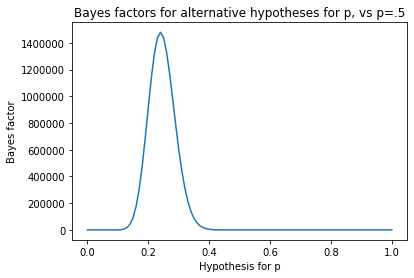

In [2]:
alpha = 24
beta = 76

h_naught = 0.5
alt_hypotheses = np.arange(0,1.01,0.01)

def bayes_factor(h_top,h_bottom,successes,failures):
    likelihood_top = h_top**successes * (1-h_top)**failures
    likelihood_bottom = h_bottom**successes * (1-h_bottom)**failures
    return likelihood_top / likelihood_bottom

bfs = bayes_factor(alt_hypotheses, h_naught, alpha, beta)

# Plotting Bayes factors
plt.plot(alt_hypotheses,bfs)
plt.title('Bayes factors for alternative hypotheses for p, vs p=.5')
plt.xlabel('Hypothesis for p')
plt.ylabel('Bayes factor')
plt.show()

Text(0, 0.5, 'Prior odds')

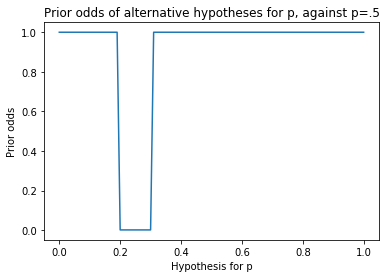

In [3]:
# Defining some prior odds. Based on priors of 0.5 for values outside of 0.2-0.3 and priors of 0.0005 for vales between 0.2-0.3 
prior_odds = np.zeros_like(alt_hypotheses)

for i in range(prior_odds.shape[0]):
    if alt_hypotheses[i] >= 0.2 and alt_hypotheses[i] <= 0.3:
        prior_odds[i] = 1/1000
    else:
        prior_odds[i] = 1

# Plotting priors
plt.plot(alt_hypotheses, prior_odds)
plt.title('Prior odds of alternative hypotheses for p, against p=.5')
plt.xlabel('Hypothesis for p')
plt.ylabel('Prior odds')

Text(0, 0.5, 'Posterior odds')

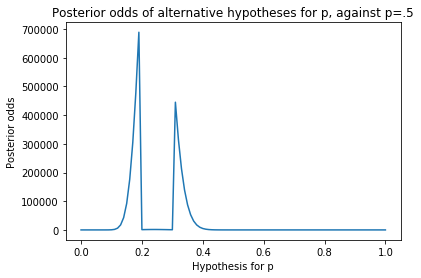

In [4]:
# Calculating posterior odds
post_odds = prior_odds * bfs

# Plotting posterior odds
plt.plot(alt_hypotheses, post_odds)
plt.title('Posterior odds of alternative hypotheses for p, against p=.5')
plt.xlabel('Hypothesis for p')
plt.ylabel('Posterior odds')

Text(0, 0.5, 'Probability')

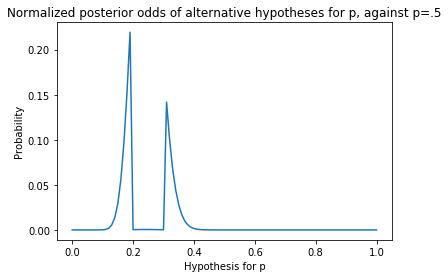

In [5]:
# Establishing a probability distribution by normalizing
norm_post_odds = post_odds / post_odds.sum()

# Plotting probability distribution of true success rate p
plt.plot(alt_hypotheses, norm_post_odds)
plt.title('Normalized posterior odds of alternative hypotheses for p, against p=.5')
plt.xlabel('Hypothesis for p')
plt.ylabel('Probability')

In [6]:
# Finding most likely estimate of true success rate p
p_max = alt_hypotheses[np.argmax(norm_post_odds)]
print(p_max)

0.19


#### Q1: Repeating the calculations with the assumption of H<sub>0</sub>: <i>p</i>=0.24. Will it alter the results?

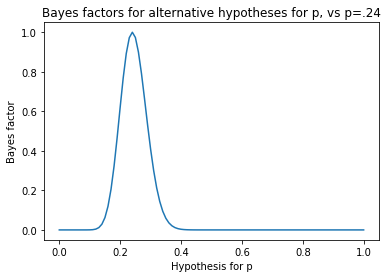

In [7]:
h_naught_q1 = 0.24
bfs_q1 = bayes_factor(alt_hypotheses, h_naught_q1, alpha, beta)

# Plotting Bayes factors
plt.plot(alt_hypotheses,bfs_q1)
plt.title('Bayes factors for alternative hypotheses for p, vs p=.24')
plt.xlabel('Hypothesis for p')
plt.ylabel('Bayes factor')
plt.show()

<b>Changing H<sub>0</sub> changes the magnitude of the Bayes factor, but not the shape of the distribution. So, it is not expected to change the most likely estimate. Let's verify.</b>

0.19


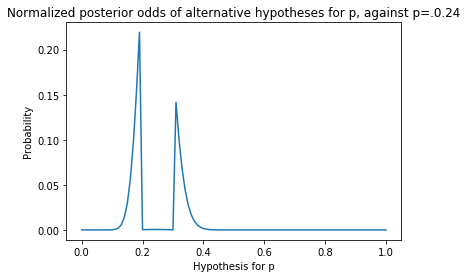

In [8]:
# Prior odds are the sane. Calculating new posterior odds
post_odds_q1 = prior_odds * bfs_q1

# Establishing the new probability distribution by normalizing
norm_post_odds_q1 = post_odds_q1 / post_odds_q1.sum()

# Plotting new probability distribution of true success rate p
plt.plot(alt_hypotheses, norm_post_odds_q1)
plt.title('Normalized posterior odds of alternative hypotheses for p, against p=.0.24')
plt.xlabel('Hypothesis for p')
plt.ylabel('Probability')

# Finding most likely estimate for p
p_max_q1 = alt_hypotheses[np.argmax(norm_post_odds_q1)]
print(p_max_q1)

<b>Indeed, the most likely estimate of the success rate is still <i>p</i>=0.19, and it's probabibility is still around 22%. This is due to the normalisation step.</b>

#### Q2: Change the priors to that each probability is 1.05x as likely as the previous

Text(0, 0.5, 'Prior odds')

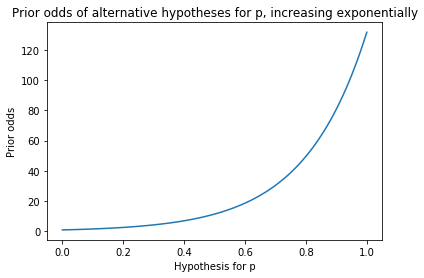

In [9]:
prior_odds_q2 = [1.05**i for i in range(prior_odds.shape[0])]
prior_odds_q2[:5]

# Plotting new priors
plt.plot(alt_hypotheses, prior_odds_q2)
plt.title('Prior odds of alternative hypotheses for p, increasing exponentially')
plt.xlabel('Hypothesis for p')
plt.ylabel('Prior odds')

0.25


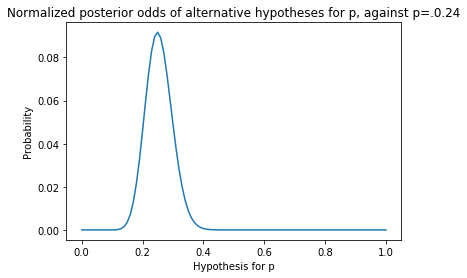

In [10]:
# Calculating new posterior odds
post_odds_q2 = prior_odds_q2 * bfs

# Establishing the new probability distribution by normalizing
norm_post_odds_q2 = post_odds_q2 / post_odds_q2.sum()

# Plotting new probability distribution of true success rate p
plt.plot(alt_hypotheses, norm_post_odds_q2)
plt.title('Normalized posterior odds of alternative hypotheses for p, against p=.0.24')
plt.xlabel('Hypothesis for p')
plt.ylabel('Probability')

# Finding most likely estimate for p
p_max_q2 = alt_hypotheses[np.argmax(norm_post_odds_q2)]
print(p_max_q2)

<b>This does shift the distribution slightly to the right as seen by the new most likely estimate being <i>p</i>=0.25. However, tjhe probabilities for values beyond <i>p</i>=0.4 remains very low, because their Bayes factor is very low.</b>